In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import cv2

## Data Preprocessing

In [3]:
# Paths and Parameters
BASE_DIR = '/kaggle/input/kvasir-capsule-labelled-images-extracted/Processed_Kvasir_labeled_images'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

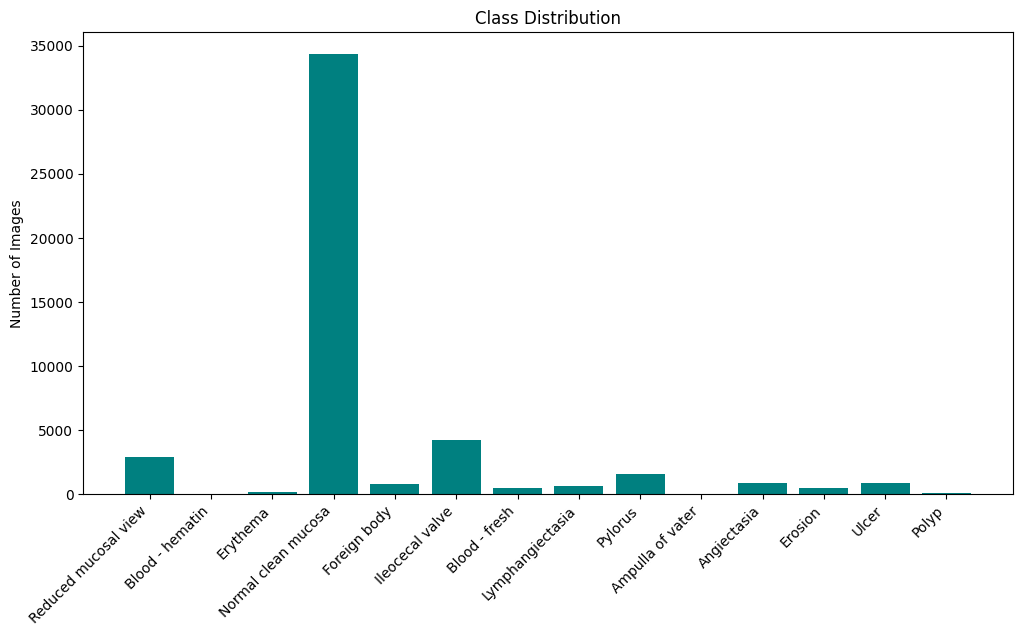

Class Counts: {'Reduced mucosal view': 2906, 'Blood - hematin': 12, 'Erythema': 159, 'Normal clean mucosa': 34338, 'Foreign body': 776, 'Ileocecal valve': 4189, 'Blood - fresh': 446, 'Lymphangiectasia': 592, 'Pylorus': 1529, 'Ampulla of vater': 10, 'Angiectasia': 866, 'Erosion': 506, 'Ulcer': 854, 'Polyp': 55}


In [4]:
# Class distribution
class_counts = {}
for class_name in os.listdir(BASE_DIR):
    class_path = os.path.join(BASE_DIR, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot Class Distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

print("Class Counts:", class_counts)

In [5]:
# Class weights
total_samples = sum(class_counts.values())
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts.values())}
print("Class Weights:", class_weights)

Class Weights: {0: 1.1610952708681546, 1: 281.17857142857144, 2: 21.221024258760107, 3: 0.09826264945957415, 4: 4.348122238586156, 5: 0.8054769293728472, 6: 7.565342729019859, 7: 5.699565637065637, 8: 2.2067644585630197, 9: 337.4142857142857, 10: 3.896238865061036, 11: 6.668266516092603, 12: 3.9509869521579124, 13: 61.348051948051946}


In [6]:
class_names = []
for class_name in os.listdir(BASE_DIR):
    class_names.append(class_name)

In [7]:
class_names = list(class_counts.keys())  # Get class names
counts = list(class_counts.values())  # Get class counts
weights = [total_samples / (len(class_counts) * count) for count in counts]

In [8]:
class_names

['Reduced mucosal view',
 'Blood - hematin',
 'Erythema',
 'Normal clean mucosa',
 'Foreign body',
 'Ileocecal valve',
 'Blood - fresh',
 'Lymphangiectasia',
 'Pylorus',
 'Ampulla of vater',
 'Angiectasia',
 'Erosion',
 'Ulcer',
 'Polyp']

NameError: name 'x' is not defined

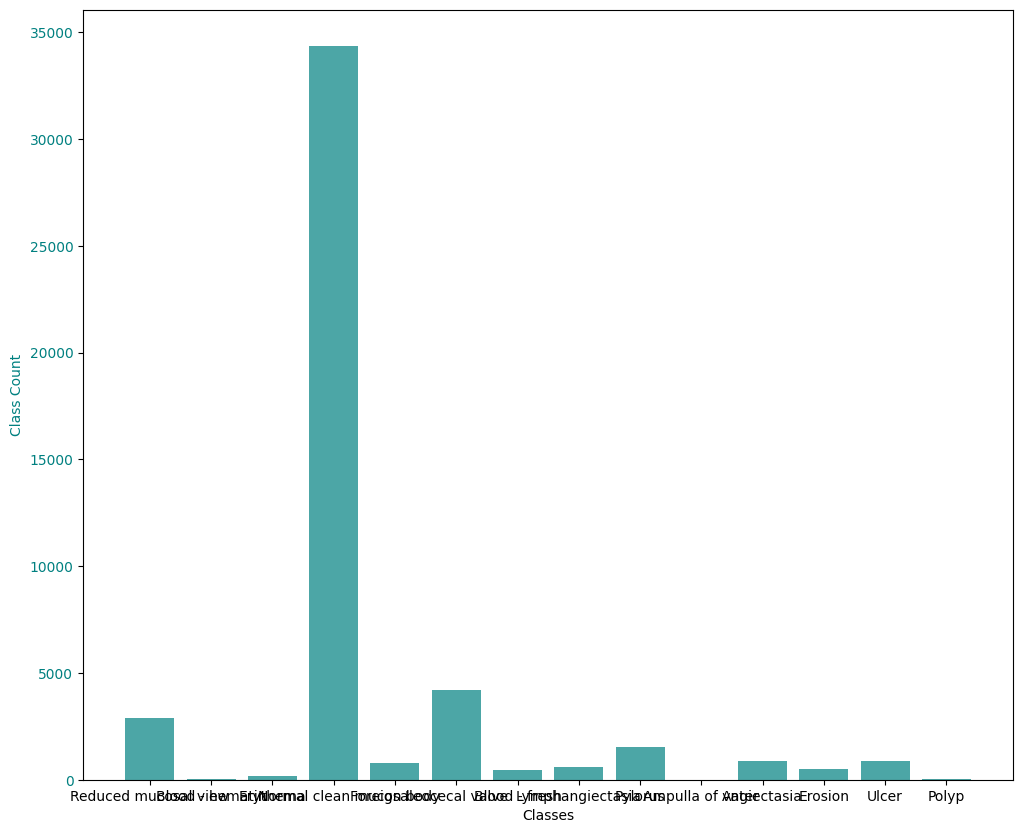

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 10))

# counts on the primary y-axis
ax1.bar(class_names, counts, color='teal', alpha=0.7, label='Class Count')
ax1.set_ylabel('Class Count', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.set_xlabel('Classes')
ax1.set_xticks(x)  
ax1.set_xticklabels(class_names, rotation=45, ha='right')

# weights on a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(class_names, weights, color='indianred', marker='o', linestyle='--', label='Class Weight')
ax2.set_ylabel('Class Weight', color='indianred')
ax2.tick_params(axis='y', labelcolor='indianred')

plt.title('Class-wise Count vs Weight')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [10]:
# Data generators

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% Validation Split

train_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 37796 images belonging to 14 classes.
Found 9442 images belonging to 14 classes.


## Model Building

In [11]:
# CNN Model

def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
# ResNet50 model (pre-trained)

def create_resnet(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the base model
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Training and Evaluation

In [13]:
input_shape = IMG_SIZE + (3,)
num_classes = len(class_counts)

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
# CNN Training
cnn_model = create_cnn(input_shape, num_classes)
cnn_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, class_weight=class_weights)

Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 202s 165ms/step - accuracy: 0.7208 - loss: 56.2287 - val_accuracy: 0.7273 - val_loss: 2.4573
Epoch 2/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 102s 86ms/step - accuracy: 0.7260 - loss: 38.2274 - val_accuracy: 0.7273 - val_loss: 2.0138
Epoch 3/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 96s 81ms/step - accuracy: 0.7359 - loss: 28.5983 - val_accuracy: 0.7268 - val_loss: 2.0357
Epoch 4/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 96s 81ms/step - accuracy: 0.7474 - loss: 23.4890 - val_accuracy: 0.7281 - val_loss: 2.2780
Epoch 5/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 96s 81ms/step - accuracy: 0.7480 - loss: 22.4683 - val_accuracy: 0.7239 - val_loss: 2.0407
Epoch 6/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 96s 81ms/step - accuracy: 0.7564 - loss: 19.8177 - val_accuracy: 0.7255 - val_loss: 1.9842
Epoch 7/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 99s 83ms/step - accuracy: 0.7656 - loss: 16.7495 - val_accuracy: 0.7254 - val_loss: 2.1850
Epoch 8/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 102s 86ms/step - accurac

In [16]:
# ResNet Training
resnet_model = create_resnet(input_shape, num_classes)
resnet_history = resnet_model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, class_weight=class_weights)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 117s 89ms/step - accuracy: 0.7244 - loss: 61.5484 - val_accuracy: 0.7273 - val_loss: 1.9933
Epoch 2/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 102s 86ms/step - accuracy: 0.7279 - loss: 47.1316 - val_accuracy: 0.7273 - val_loss: 1.7565
Epoch 3/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 99s 83ms/step - accuracy: 0.7275 - loss: 47.3861 - val_accuracy: 0.7273 - val_loss: 2.2240
Epoch 4/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 100s 84ms/step - accuracy: 0.7297 - loss: 45.6226 - val_accuracy: 0.7273 - val_loss: 2.0617
Epoch 5/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 101s 85ms/step - accuracy: 0.7239 - loss: 44.7502 - val_accuracy: 0.7273 - val_loss: 1.9466
Epoch 6/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 100s 84ms/step - accuracy: 0.7221 - loss: 45.0018 - val_accuracy: 0.7273 - val_loss: 2.1397
Epoch 7/20
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 101s 85ms/step - accuracy: 0.7276 - loss: 44.1024 - val_accuracy: 0.7273 - val_loss: 1.8722
Epoch 8/20
1

In [17]:
def plot_results(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')

    plt.show()

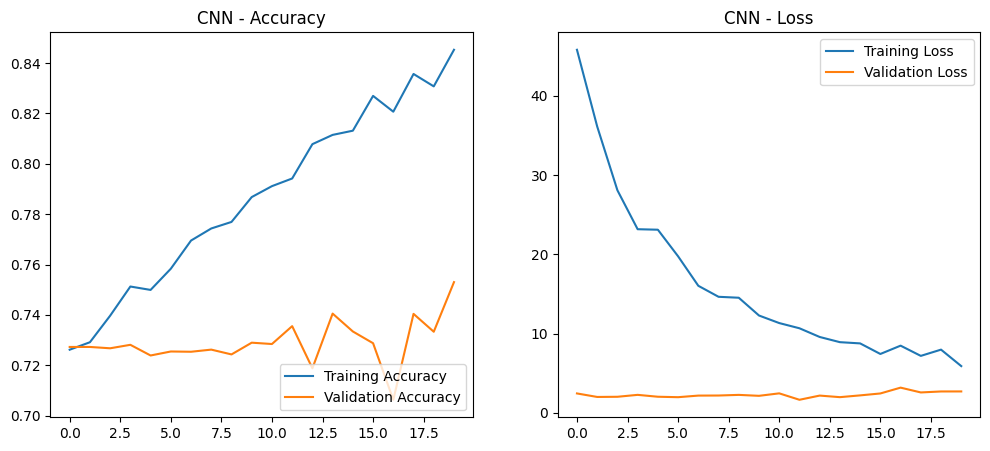

In [18]:
plot_results(cnn_history, "CNN")

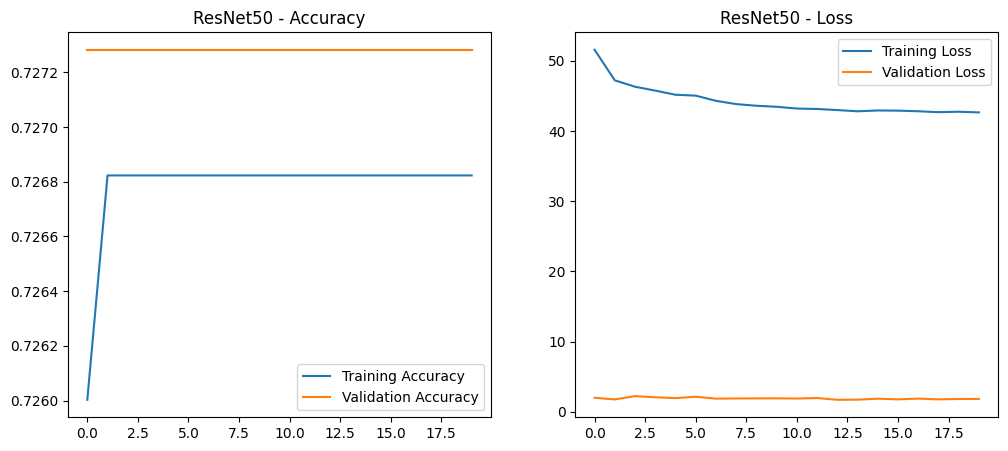

In [19]:
plot_results(resnet_history, "ResNet50")

In [29]:
def plot_confusion_matrix(model, test_data, class_names, cmap='Blues'):
    # Get true labels and predictions
    y_true = []
    y_pred = []
    
    for images, labels in test_data:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)
        y_true.extend(labels)
        y_pred.extend(preds)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(12, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=cmap, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
def generate_gradcam_heatmap(model, img_array, class_index, layer_name=None):
    # Find the last convolutional layer if not provided
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break
    
    # Create a model that maps input to the activations of the conv layer and output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weigh the activation map with the pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    
    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def plot_gradcam(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    superimposed_img = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

In [ ]:
plot_confusion_matrix(cnn_model, val_generator, class_names)

In [ ]:
plot_confusion_matrix(resnet_model, val_generator, class_names)

#### Evaluate and compare

In [20]:
cnn_val_acc = cnn_model.evaluate(val_generator)[1]
resnet_val_acc = resnet_model.evaluate(val_generator)[1]

print(f"CNN Validation Accuracy: {cnn_val_acc:.2%}")
print(f"ResNet50 Validation Accuracy: {resnet_val_acc:.2%}")

296/296 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.5853 - loss: 6.4327
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.5431 - loss: 2.9401
CNN Validation Accuracy: 75.30%
ResNet50 Validation Accuracy: 72.73%


In [31]:
cnn_model.save('kvasir_cnn_model1.h5')
cnn_model.save('kvasir_cnn_model1.keras')

resnet_model.save('kvasir_resnet_model1.h5')
resnet_model.save('kvasir_resnet_model1.keras')